## Assignement_3

Generative Adversarial Text-to-Image Synthesis
In this assignment, you will learn about text-to-image synthesis using conditional GANs. A typical GAN has a
Generator (G) that takes random noise as input to generate realistic data samples (e.g., images or audio or text) and
a Discriminator (D) that acts as a binary classifier, distinguishing between real and generated data. In Conditional
GANs, input to (G) is conditioned over additional information.
In this assignment, you have to train a conditional GAN to generate images where input to Target Generator
(G) is conditioned over textual descriptions. In addition, you have to train a Source Encoder, which will provide
learned representations as input to (G) instead of noise. You may train the whole setup in an end-to-end manner or
in parts. For instance, one approach could be knowledge distillation from source encoder to generator.
Overall Setup:
1. Source Encoder: Takes input image and outputs a representation. Any model size or type.
2. Target Generator: Takes representations from the source model and text encoding to generate new samples.
The number of parameters should be half of that of the Source Encoder. Any model type.
3. Discriminator: Distinguishes between real and generated data. Any model size or type.

#### 1. Lets Import all the necessary Libraries/Packages 

In [ ]:
# Common python packages
import datetime
import os
import sys
import time
import h5py
import random
import io


# torch stuff
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# torchsummary and torchvision
from torchsummary import summary
from torchvision.utils import save_image

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

#skit_learn
from sklearn.manifold import TSNE

# numpy and pandas
import numpy as np
import pandas as pd

#pillow lib
from PIL import Image

#for correct text wrap
import textwrap


#### 2.Fetching The Dataset

The script uses the h5py library to handle the HDF5 file format. The dataset is  structured with separate groups for training (train), testing (test), and validation (valid). Each group contains multiple entries, each with an associated class label.

In [167]:

hdf5_path = "/kaggle/input/image-text/flowers.hdf5"

# Load HDF5 file
with h5py.File(hdf5_path, 'r') as file:
    def get_classes(split_name):
        split = file[split_name]
        class_list = set()
        for key in split.keys():
            class_label = int(split[key]["class"][()].decode('utf-8').split('_')[-1])
            class_list.add(class_label)
        return sorted(list(class_list)) 

    train_classes = get_classes("train")
    test_classes = get_classes("test")
    valid_classes = get_classes("valid")

    print(f"Available Train Classes: {train_classes}")
    print(f"Available Test Classes: {test_classes}")
    print(f"Available Valid Classes: {valid_classes}")

Available Train Classes: [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]
Available Test Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Available Valid Classes: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


#### 2.1 Selecting Existing Classes for Training and Testing:

This function selects a specified number of training and testing classes from the available dataset:

*  There are 102 possible classes in the Oxford-102 dataset.

* It filters training classes from the available training set and randomly selects the 20 training classes.

* It filters testing classes from the available test set and randomly selects the 5 test classes.




In [168]:

def select_existing_classes(train_classes_count, test_classes_count, valid_classes):
    # Ensure we select from existing classes
    available_classes = list(range(1, 103)) 
    
    available_train_classes = list(set(available_classes) & set(train_classes))  
    random.shuffle(available_train_classes)
    train_classes_selected = available_train_classes[:train_classes_count]

    # Select test classes only from those available in 'test' split
    available_test_classes = list(set(available_classes) & set(test_classes))
    random.shuffle(available_test_classes)
    test_classes_selected = available_test_classes[:test_classes_count]

    return train_classes_selected, test_classes_selected

# Run Selection
train_classes, test_classes = select_existing_classes(20, 5, valid_classes)

print(f"Selected Train Classes: {train_classes}")
print(f"Selected Test Classes: {test_classes}")

Selected Train Classes: [44, 102, 95, 80, 57, 63, 53, 89, 76, 70, 81, 99, 45, 64, 74, 68, 73, 75, 85, 54]
Selected Test Classes: [18, 14, 12, 7, 11]


###  2.2 Flower Dataset

Let's create a custom FlowerDataset class to easily have access to the data.
* It loads the dataset split from the HDF5 file.

* Filters samples based on selected classes.

* Reads and processes image data.

* Converts text embeddings into a suitable format: (201,10) uint8 → (2010,) float32

* Extracts the class label and text description.

* Applies image transformations pipeline resizes images to 64x64, converts them to tensors, and normalizes them.

In [169]:

class FlowerDataset(Dataset):
    def __init__(self, hdf5_path, split, transform=None, selected_classes=None):
        self.file = h5py.File(hdf5_path, 'r')
        self.split = self.file[split]
        self.keys = list(self.split.keys())
        self.transform = transform

        self.filtered_keys = []
        for key in self.keys:
            class_label = int(self.split[key]["class"][()].decode('utf-8').split('_')[-1])  # Convert from bytes
            if selected_classes is None or class_label in selected_classes:
                self.filtered_keys.append(key)

    def __len__(self):
        return len(self.filtered_keys)

    def __getitem__(self, idx):
        sample = self.split[self.filtered_keys[idx]]

        img_data = sample["img"][()]
        img = Image.open(io.BytesIO(img_data)).convert("RGB") 

        #  Convert text embeddings from (201,10) uint8 → (2010,) float32
        embedding = np.array(sample["embeddings"], dtype=np.float32).reshape(-1)

        class_label = int(sample["class"][()].decode('utf-8').split('_')[-1])

        text_description = sample["txt"][()].decode('utf-8')

        #  Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(embedding, dtype=torch.float32), class_label, text_description

#Resizes image to 64*64
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])





So In this section we create a three dataset **train_dataset,test_dataset,& valid_dataset**
after that we have created three dataloader for the batch processing with the batch size 4 where  each batch contain 4 samples :**images ,embeddings,class labels,and text_descriptions.**

In [170]:
train_dataset = FlowerDataset(hdf5_path, split="train", transform=transform, selected_classes=train_classes)
test_dataset = FlowerDataset(hdf5_path, split="test", transform=transform, selected_classes=test_classes)
valid_dataset = FlowerDataset(hdf5_path, split="valid", transform=transform)  

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

print(f"Final Train Samples: {len(train_dataset)}")
print(f"Final Test Samples: {len(test_dataset)}") 
print(f"Final Validation Samples: {len(valid_dataset)}")

for imgs, embeddings, labels, descriptions in train_loader:
    print("Batch of images:", imgs.shape)
    print("Batch of embeddings:", embeddings.shape)
    print("Batch of class labels:", labels)
    print("Batch of descriptions:", descriptions)
    break  

Final Train Samples: 100
Final Test Samples: 25
Final Validation Samples: 100
Batch of images: torch.Size([4, 3, 64, 64])
Batch of embeddings: torch.Size([4, 2010])
Batch of class labels: tensor([ 45, 102,  63,  74])
Batch of descriptions: ('the flower has petals that are lavender with golden anther and green filaments.\n', 'this flower has sparsely arranged yellow and orange petals with darker orange spots on them.\n', 'this yellow flower has pointed petals and a green pedicel.\n', 'layers of pink edged petals that are yellow and a green sepul and pedicel.\n')


## 3.Source_Encoder

**Source_Encoder**, encodes an input image into a 512-dimensional feature vector,It contains four layers with increasing channel size each layer is  followed by a activation function LeakyRelu with a 0.2 slope and Batchnormalization.

In [81]:
class SourceEncoder(nn.Module):
    def __init__(self):
        super(SourceEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.flatten_size = None  

        self.fc = None  

    def forward(self, x):
        x = self.conv_layers(x)

        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).shape[1]  
            self.fc = nn.Linear(self.flatten_size, 512).to(x.device)  
        
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x



## 4. GeneratorUnet

The GeneratorUNet generates images using a combination of text and image inputs. This architecture is based on a U-Net structure, enhanced with text and latent embeddings.
#### The generator takes an input image, a text embedding, and a source encoding to produce a transformed output image.
### Architecture
* Text and Latent Encoders

* U-Net Downsampling (Contracting Path)

* Bottleneck with Text & Latent Feature Fusion

* U-Net Upsampling (Expanding Path)

* Final Output Layer

* The generator will have a U-Net architecture with the following characteristics:

* the descending blocks are convolutional layers followed by instance normalization with a LeakyReLU activation function;

* the ascending blocks are transposed convolutional layers followed by instance normalization with a ReLU activation function.



In [82]:


class UNetDown(nn.Module):
    """Descending block of the U-Net."""
    def __init__(self, in_size, out_size):
        super(UNetDown, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1)
        self.norm = nn.InstanceNorm2d(out_size) if out_size > 1 else None
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.norm is not None and x.shape[-2] > 1 and x.shape[-1] > 1:
            x = self.norm(x)
        x = self.activation(x)
        return x


class UNetUp(nn.Module):
    """Ascending block of the U-Net."""
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.match_channels = nn.Conv2d(in_size, out_size, kernel_size=1)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.model(x)
        return x


class FinalLayer(nn.Module):
    """Final block of the U-Net."""
    def __init__(self, in_size, out_size):
        super(FinalLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), dim=1)
        x = self.model(x)
        return x



#### 3.2.Data Flow & Processing

1. Text and Latent Encoding

* The text embedding (2010-dimensional) is passed through a three-layer fully connected neural network to generate a 256-dimensional feature vector.

* The source encoding  is processed through a separate fully connected layer to generate another 256-dimensional vector.

* Both the text and source feature vectors are reshaped and interpolated to (4 × 4 spatial size) for fusion with image features.

2. U-Net Downsampling (Contracting Path)

* The input image is passed through six convolutional layers (UNetDown blocks), progressively reducing the spatial dimensions while increasing depth.

* The output feature maps from each downsampling step are stored for later skip connections in the upsampling phase.

3. Bottleneck: Fusing Text & Latent Features

* The deepest feature map (from the last downsampling layer) is resized to (4 × 4 spatial size).

* This map is concatenated with the text and source features, increasing the number of channels.

* A 1×1 convolution is applied to reduce channel dimensions before passing through a bottleneck convolutional layer.

4. U-Net Upsampling (Expanding Path)

* The upsampling path mirrors the downsampling path but includes skip connections to retain fine-grained details.

* Feature maps from earlier downsampling layers are resized and concatenated at each upsampling step.

* 1×1 convolutions are used to adjust channel dimensions before applying transpose convolutions for upsampling.

5. Final Image Generation

* The last feature map is passed through a final convolutional layer (FinalLayer) to generate the output image.

* The output has the same number of channels as the input image, maintaining its RGB format.

In [83]:


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, text_embed_dim=2010, latent_dim=512):
        super(GeneratorUNet, self).__init__()

        # Text and latent encoders
        self.text_encoder = nn.Sequential(
            nn.Linear(text_embed_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.latent_encoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU()
        )

        # U-Net downsampling layers
        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)

        # Reduce concatenated channels before bottleneck
        self.bottleneck_reduce = nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Reduce concatenated channels before passing into upsampling layers
        self.channel_reduce1 = nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0)  # Before up1
        self.channel_reduce2 = nn.Conv2d(768, 256, kernel_size=1, stride=1, padding=0)   # Before up2
        self.channel_reduce3 = nn.Conv2d(384, 128, kernel_size=1, stride=1, padding=0)   # Before up3

        # U-Net upsampling layers
        self.up1 = UNetUp(512, 256)
        self.up2 = UNetUp(256, 128)
        self.up3 = UNetUp(128, 64)

        # Reduce final concatenated channels before FinalLayer
        self.final_reduce = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0)  
        self.final = FinalLayer(64, out_channels)  

    def forward(self, image, text_embedding, source_encoding):
        # Encode text and latent input
        text_feat = self.text_encoder(text_embedding)
        source_feat = self.latent_encoder(source_encoding)

        # Reshape and interpolate text and source features
        text_feat = text_feat.view(text_feat.size(0), 256, 1, 1)
        source_feat = source_feat.view(source_feat.size(0), 256, 1, 1)
        text_feat = F.interpolate(text_feat, size=(4, 4), mode="bilinear", align_corners=False)
        source_feat = F.interpolate(source_feat, size=(4, 4), mode="bilinear", align_corners=False)

        # Downsampling
        d1 = self.down1(image)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        # Resize d6 to (batch, 512, 4, 4)
        d6 = F.interpolate(d6, size=(4, 4), mode="bilinear", align_corners=False)

        # Concatenate and reduce channels before bottleneck
        bottleneck_input = torch.cat((d6, text_feat, source_feat), dim=1)  # [batch, 1024, 4, 4
        bottleneck_input = self.bottleneck_reduce(bottleneck_input)  #  Reduce 1024 → 512
        bottleneck_output = self.bottleneck(bottleneck_input)

        # Upsampling with skip connections
        d5_resized = F.interpolate(d5, size=bottleneck_output.shape[2:], mode="bilinear", align_corners=False)
        u1_input = torch.cat((bottleneck_output, d5_resized), dim=1)  # [batch, 1024, 4, 4]
        u1_input = self.channel_reduce1(u1_input)  # Reduce 1024 → 512
        u1 = self.up1(u1_input)

        d4_resized = F.interpolate(d4, size=u1.shape[2:], mode="bilinear", align_corners=False)
        u2_input = torch.cat((u1, d4_resized), dim=1)
        u2_input = self.channel_reduce2(u2_input)  # Reduce 768 → 256
        u2 = self.up2(u2_input)

        d3_resized = F.interpolate(d3, size=u2.shape[2:], mode="bilinear", align_corners=False)
        u3_input = torch.cat((u2, d3_resized), dim=1)
        u3_input = self.channel_reduce3(u3_input)  # Reduce 384 → 128
        u3 = self.up3(u3_input)

        # Reduce concatenation before FinalLayer
        d1_resized = F.interpolate(d1, size=u3.shape[2:], mode="bilinear", align_corners=False)
        final_input = torch.cat((u3, d1_resized), dim=1)  # [batch, 128, 64, 64]
        final_input = self.final_reduce(final_input)  #  Reduce 128 → 64
        out = self.final(final_input)

        return out





Testing of a Generator Output 

In [84]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = GeneratorUNet().to(device)

# Dummy inputs for testing
batch_size = 4
image = torch.randn(batch_size, 3, 256, 256).to(device)
text_embedding = torch.randn(batch_size, 2010).to(device)
source_encoding = torch.randn(batch_size, 512).to(device)

# Forward pass test
output = generator(image, text_embedding, source_encoding)
print("Generator Output Shape:", output.shape)  # Expected: [4, 3, 256, 256]

Generator Output Shape: torch.Size([4, 3, 64, 64])


## 5. Descriminator

The discriminator processes both image data and conditional information to make real/fake predictions. It follows a pattern with progressive downsampling while increasing feature channels.For the discriminator we will use a two-dimensional convolutional neural network with 5 layers:

* the first 4 layers are 2D-convolutional layers with a LeakyReLU activation function;

* the last layer is a 2D-convolutional layer.


Feature Progression
* Condition Integration: Early fusion strategy by concatenating with image features
* Output: Single scalar value per image for real/fake classification

Initial: 4 channels (RGB + condition) at 64×64 resolution
* Progressive feature channel expansion: 4 → 64 → 128 → 256 → 512
* Progressive spatial reduction: 64×64 → 32×32 → 16×16 → 8×8 → 4×4 → 1×1

In [85]:

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, condition_dim=2010):  
        super(Discriminator, self).__init__()

        # Adjust projection layer to accept 2010 features
        self.condition_projector = nn.Linear(condition_dim, 64 * 64)  

        # Layer 1: (in_channels + 1, 64, 64) -> (64, 32, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, 64, kernel_size=3, stride=2, padding=1),  
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Layer 2: (64, 32, 32) -> (128, 16, 16)
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Layer 3: (128, 16, 16) -> (256, 8, 8)
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Layer 4: (256, 8, 8) -> (512, 4, 4)
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Layer 5 (Final layer): Reduce output to (batch_size, 1, 1, 1)
        self.final_layer = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

    def forward(self, x, condition):
        batch_size = x.size(0)
    
    
        # Ensure `condition` is correctly shaped
        if condition.dim() > 2:
            condition = condition.view(batch_size, -1)  
    
        # Check condition size before projection
        assert condition.shape[1] == self.condition_projector.in_features, \
            f"Expected condition shape (batch, {self.condition_projector.in_features}), got {condition.shape}"
    
        # Project condition to match spatial size
        condition = self.condition_projector(condition)  
        condition = condition.view(batch_size, 1, 64, 64) 
    
        if condition.shape[2:] != x.shape[2:]:
            condition = F.interpolate(condition, size=x.shape[2:], mode="bilinear", align_corners=False)
    
        x = torch.cat([x, condition], dim=1)  

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Reduce to (batch_size, 1, 1, 1)
        x = self.final_layer(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))  
        
        return x





In [86]:
def test_discriminator():
    # Create sample input tensors
    batch_size = 4
    image_size = 64
    condition_dim = 64 

    x = torch.randn(batch_size, 1, image_size, image_size)

    # Sample condition tensor (matching expected input)
    condition = torch.randn(batch_size, condition_dim)

    discriminator = Discriminator(in_channels=1, condition_dim=condition_dim)

    output = discriminator(x, condition)

    # Print shapes
    print(f"Input shape: {x.shape}")
    print(f"Condition shape: {condition.shape}")
    print(f"Output shape: {output.shape}")

    

test_discriminator()



Input shape: torch.Size([4, 1, 64, 64])
Condition shape: torch.Size([4, 64])
Output shape: torch.Size([4, 1, 1, 1])


## 6.Training

The model integrates a Source Encoder, Generator, and Discriminator to generate images conditioned on textual descriptions and real images. The training process follows an adversarial training approach utilizing Adam optimizers with a learning rate of 0.0002.
The training process involves three sub-steps:

Step 1: Train Discriminator (D)

* Compute predictions for real and fake images.

* Compute BCE loss for both real and fake predictions.

* Update optimizer_D.

 Step 2: Train Generator (G)

* Generate fake images using the generator.

* Compute adversarial loss using discriminator predictions.

* Compute L1 loss between real and generated images.

Step 3: Train Source Encoder (S)

* Extract features from real images.

* Use generator to create fake images based on extracted features.

* Compute adversarial loss from discriminator.



In [ ]:

lr = 0.0002

# models initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_encoder = SourceEncoder().to(device)
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

#optimizers
optimizer_S = optim.Adam(source_encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

def train_step(real_images, text_embeddings):
    batch_size = real_images.size(0)
    source_encodings = source_encoder(real_images)

    fake_images = generator(real_images, text_embeddings, source_encodings)

    ####### Train Discriminator #######
    optimizer_D.zero_grad()
    
    # Get real and fake predictions
    real_preds = discriminator(real_images, text_embeddings)
    fake_preds = discriminator(fake_images.detach(), text_embeddings)


    real_preds = real_preds.view(-1)  #  (batch_size, 1, 1, 1) → (batch_size,)
    fake_preds = fake_preds.view(-1)  # (batch_size, 1, 1, 1) → (batch_size,)

    real_labels = torch.ones_like(real_preds)  
    fake_labels = torch.zeros_like(fake_preds)  

    # Compute discriminator loss
    d_loss = (adversarial_loss(real_preds, real_labels) + adversarial_loss(fake_preds, fake_labels)) / 2
    d_loss.backward()
    optimizer_D.step()

    ####### Train Generator #######
    optimizer_G.zero_grad()
    fake_preds = discriminator(fake_images, text_embeddings)  
    g_loss = adversarial_loss(fake_preds.view(-1), real_labels) + l1_loss(fake_images, real_images) * 100
    g_loss.backward()
    optimizer_G.step()

    ####### Train Source Encoder #######
    optimizer_S.zero_grad()
    source_encodings = source_encoder(real_images)
    fake_images = generator(real_images, text_embeddings, source_encodings)
    fake_preds = discriminator(fake_images, text_embeddings)
    s_loss = adversarial_loss(fake_preds.view(-1), real_labels)
    s_loss.backward()
    optimizer_S.step()

    return d_loss.item(), g_loss.item(), s_loss.item()

# Training Loop 
num_epochs = 200
for epoch in range(num_epochs):
    start_time = time.time()
    total_d_loss, total_g_loss, total_s_loss = 0, 0, 0
    
    for real_images, text_embeddings, _, _ in train_loader:
        real_images, text_embeddings = real_images.to(device), text_embeddings.to(device)

        #  Unpack it
        d_loss, g_loss, s_loss = train_step(real_images, text_embeddings)

        total_d_loss += d_loss
        total_g_loss += g_loss
        total_s_loss += s_loss
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {total_d_loss:.4f} | G Loss: {total_g_loss:.4f} | S Loss: {total_s_loss:.4f} | Time: {time.time() - start_time:.2f}s")






Epoch [1/200] | D Loss: 17.5121 | G Loss: 689.5855 | S Loss: 17.8885 | Time: 1.84s
Epoch [2/200] | D Loss: 17.3682 | G Loss: 430.1475 | S Loss: 17.4603 | Time: 1.64s
Epoch [3/200] | D Loss: 17.3247 | G Loss: 361.2319 | S Loss: 17.3395 | Time: 1.64s
Epoch [4/200] | D Loss: 17.3201 | G Loss: 313.2005 | S Loss: 17.5429 | Time: 1.63s
Epoch [5/200] | D Loss: 17.3585 | G Loss: 266.8535 | S Loss: 17.3811 | Time: 1.64s
Epoch [6/200] | D Loss: 17.3255 | G Loss: 257.5859 | S Loss: 17.4269 | Time: 1.66s
Epoch [7/200] | D Loss: 17.3017 | G Loss: 234.5202 | S Loss: 17.4103 | Time: 1.66s
Epoch [8/200] | D Loss: 17.3311 | G Loss: 214.7325 | S Loss: 17.5147 | Time: 1.66s
Epoch [9/200] | D Loss: 17.3329 | G Loss: 207.9963 | S Loss: 17.3433 | Time: 1.66s
Epoch [10/200] | D Loss: 17.3191 | G Loss: 186.7125 | S Loss: 17.3973 | Time: 1.63s
Epoch [11/200] | D Loss: 17.3013 | G Loss: 183.6303 | S Loss: 17.4544 | Time: 1.65s
Epoch [12/200] | D Loss: 17.3222 | G Loss: 181.7866 | S Loss: 17.3957 | Time: 1.64s
E

In [88]:
source_encoder.eval()

SourceEncoder(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Linear(in_features=8192, out_features=512, bias=True)
)

In [89]:
generator.eval()


GeneratorUNet(
  (text_encoder): Sequential(
    (0): Linear(in_features=2010, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
  )
  (latent_encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (down1): UNetDown(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (down2): UNetDown(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (down3): UNetDown(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  

### Evaluation 
1.Displaying Real Images

* Fetches a batch of real images from the training set.
* Converts them from the normalized range [-1,1] to [0,1] for proper visualization.
* Displays up to 5 images.
2.Generating and Displaying Fake Images

.Iterates over the test dataset and fetches images and text embeddings.
* Passes real images through the source encoder to obtain source encodings.
* Uses the generator to synthesize fake images using real images, text embeddings, and source encodings.
*  Displays up to 5 generated images along with their corresponding text descriptions.
* 3D t-SNE Visualization of Encoded Features

3.Extracts encoded features from the source encoder for validation images.
* Uses t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce feature dimensions to 3.
* Plots a 3D scatter plot where different colors represent different class labels.


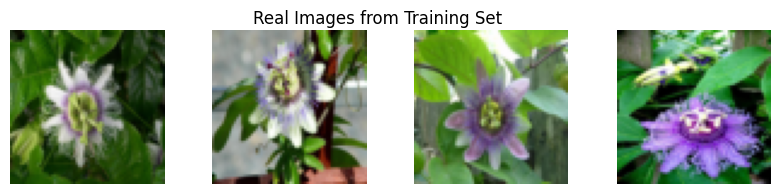

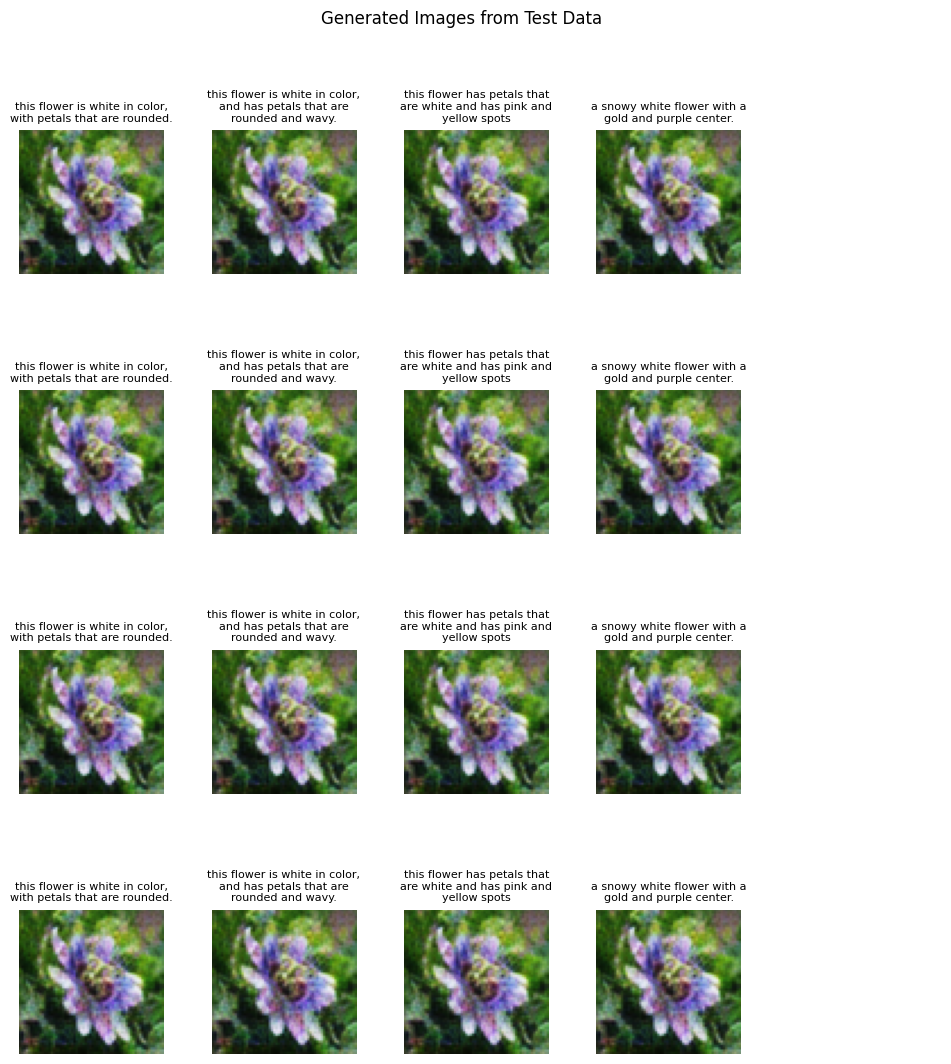

In [172]:

def visualize_images(generator, encoder, train_loader, test_loader, device):
    generator.eval()
    encoder.eval()

    def denormalize(image):
        """ Convert images from [-1,1] range to [0,1] """
        return (image * 0.5) + 0.5  

    # Show Real Images from Training Set ===
    real_images, text_embeddings, _, text_descriptions = next(iter(train_loader))
    real_images = real_images.to(device)

    num_images = min(5, real_images.size(0)) 

    fig, axs = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axs[i].imshow(denormalize(real_images[i]).permute(1, 2, 0).cpu().numpy())  
        axs[i].axis('off')
    plt.suptitle("Real Images from Training Set", fontsize=12)
    plt.show()

    # ===  Generate and Display Images from Test Data ===
    with torch.no_grad():
        for batch_idx, (real_images, text_embeddings, _, text_descriptions) in enumerate(test_loader):
            real_images, text_embeddings = real_images.to(device), text_embeddings.to(device)

            source_encodings = encoder(real_images)  

            # Generate images
            fake_images = generator(real_images, text_embeddings, source_encodings).cpu()

            num_samples = min(fake_images.size(0), 5)
            fig, axs = plt.subplots(num_samples, 5, figsize=(12, 12))
            plt.subplots_adjust(hspace=0.8)  

            for i in range(num_samples):
                for j in range(5):  
                    if j < fake_images.size(0):  
                        axs[i, j].imshow(denormalize(fake_images[j]).permute(1, 2, 0).numpy())
                        axs[i, j].axis('off')

                        #  text wrapping for 30 chars
                        wrapped_text = "\n".join(textwrap.wrap(text_descriptions[j], width=30))
                        axs[i, j].set_title(wrapped_text, fontsize=8)  
                    else:
                        axs[i, j].axis('off')  
            plt.suptitle("Generated Images from Test Data", fontsize=12)
            plt.show()
            break 


visualize_images(generator, source_encoder, train_loader, test_loader, device)


### 8.TSNE Visualisation
* The points are distributed across 3D space with distinct clustering patterns
* The color gradient (from dark blue to red) appears to represent feature values ranging from ~20 to 40
* There's a fair amount of spatial separation between points, suggesting the model has learned to differentiate between various text descriptions or flower types

* This visualization is probably showing how different text descriptions of flowers are encoded in the latent space of the GAN. Each point likely represents a specific text prompt about flowers, with nearby points representing semantically similar descriptions. The spatial relationships between points reflect semantic relationships between different flower descriptions.

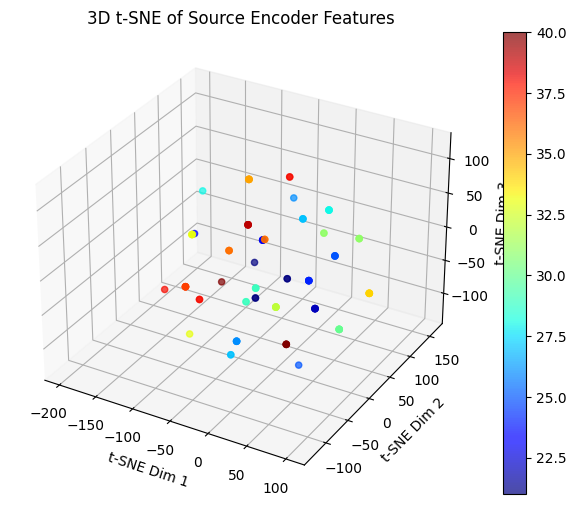

In [173]:

def visualize_tsne(encoder, valid_loader, device):
    encoder.eval()
    
    all_embeddings, all_labels = [], []

    with torch.no_grad():
        for real_images, text_embeddings, labels, _ in valid_loader:  
            real_images, text_embeddings = real_images.to(device), text_embeddings.to(device)

            # Get embeddings from Source Encoder
            embeddings = encoder(real_images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.numpy())

    all_embeddings = np.concatenate(all_embeddings)
    all_labels = np.concatenate(all_labels)

    sampled_idxs = np.random.choice(len(all_embeddings), min(1000, len(all_embeddings)), replace=False)
    sampled_embeddings = all_embeddings[sampled_idxs]
    sampled_labels = all_labels[sampled_idxs]

    tsne = TSNE(n_components=3, random_state=42)
    tsne_embeddings = tsne.fit_transform(sampled_embeddings)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], tsne_embeddings[:, 2], c=sampled_labels, cmap='jet', alpha=0.7)

    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")
    ax.set_zlabel("t-SNE Dim 3")
    plt.colorbar(scatter)
    plt.title("3D t-SNE of Source Encoder Features", fontsize=12)
    plt.show()


visualize_tsne(source_encoder, valid_loader, device)


In [174]:
def summary(models):
    print("\nModel Summary Table:\n")
    print(f"{'Model':<20}{'Total Params':<15}{'Trainable Params':<15}")
    print("="*50)
    
    for name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"{name:<20}{total_params:<15}{trainable_params:<15}")

# Print Model Summary
models = {"Source Encoder": source_encoder, "Generator": generator, "Discriminator": discriminator}
summary(models)



Model Summary Table:

Model               Total Params   Trainable Params
Source Encoder      6953152        6953152        
Generator           15708291       15708291       
Discriminator       9796801        9796801        


#### Visualisation on another flower images:

1.Generated images from the test data for the other random selection of train images 

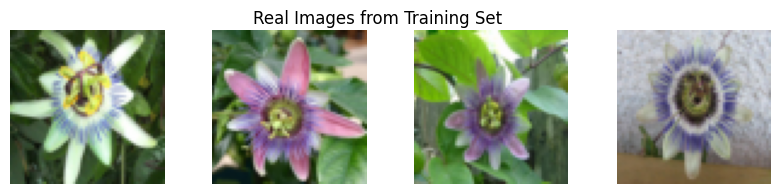

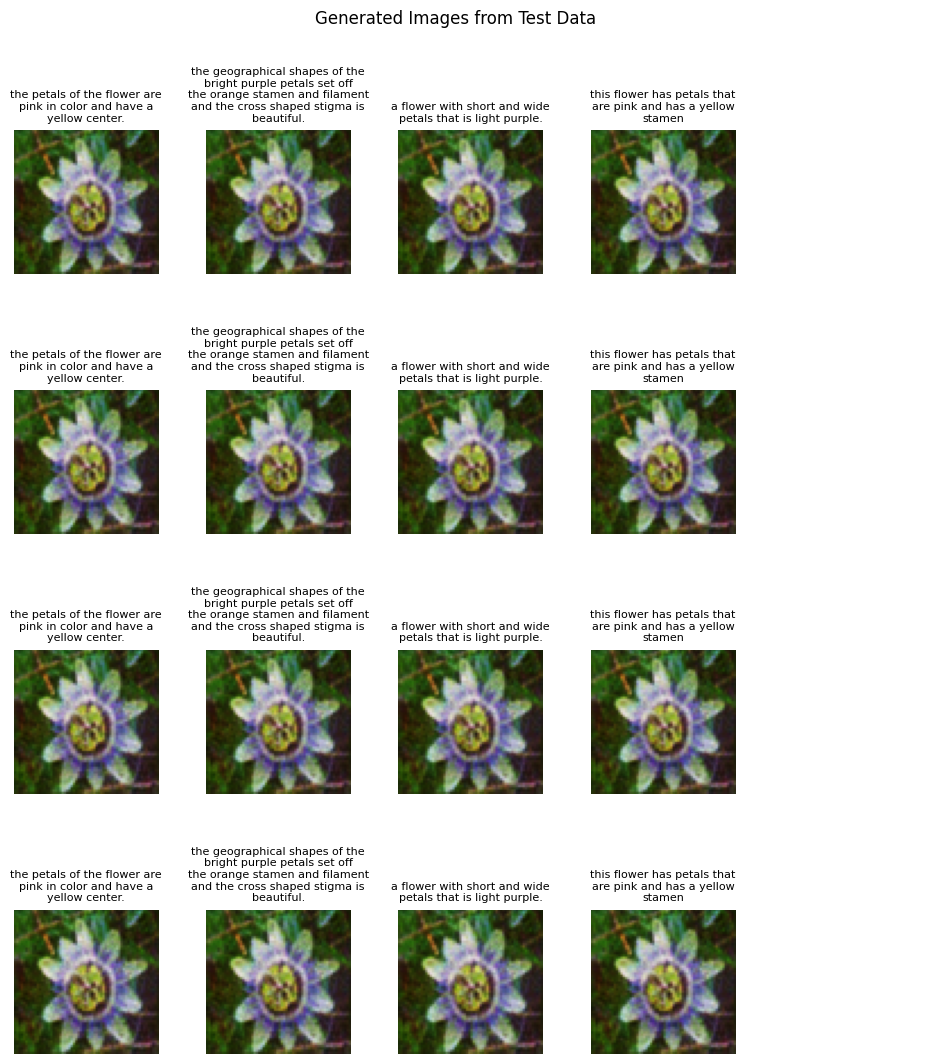

2.

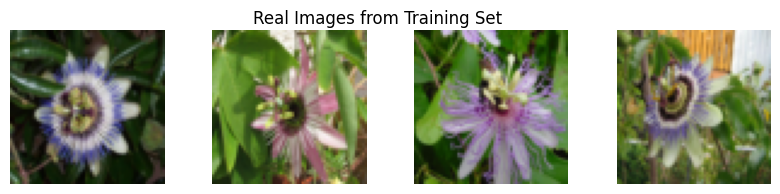

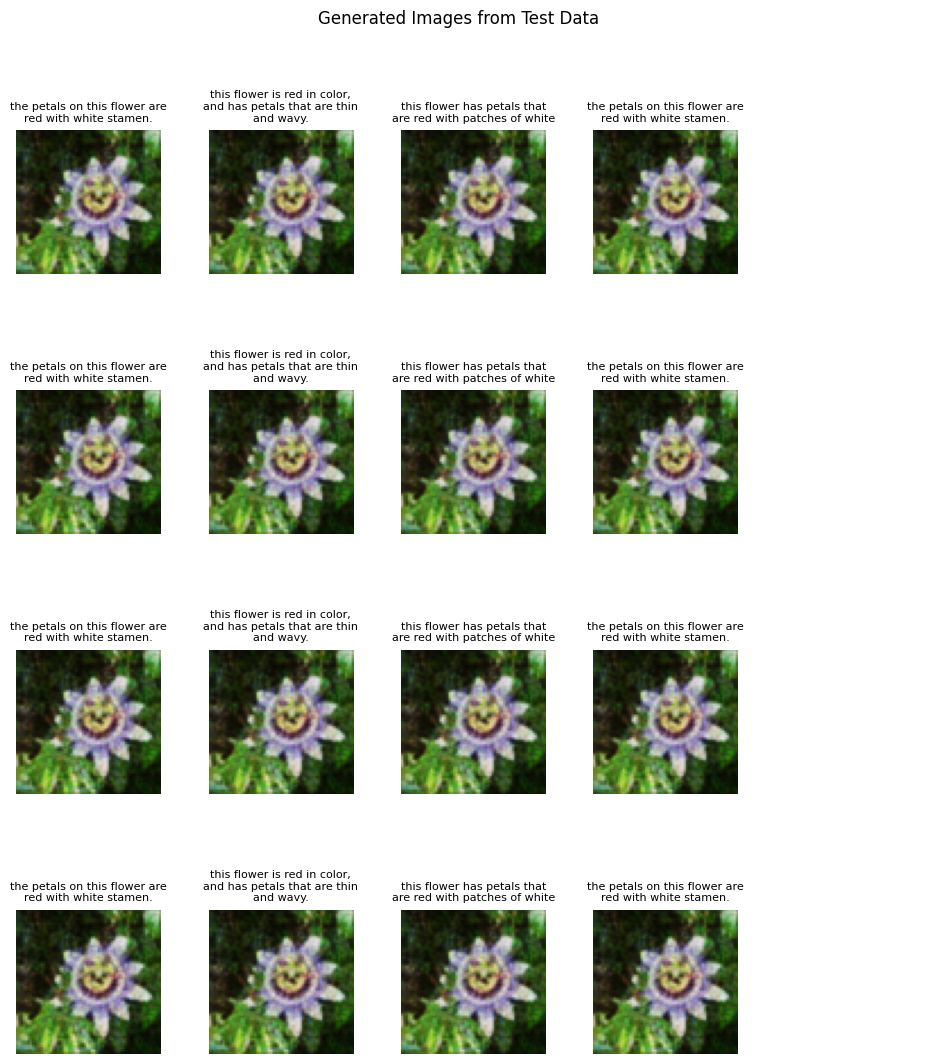

I have also tried with other architectures of generator and discriminator but the images generated by the test set are  blurry but when we add instancenorm2D after convolution layer the chnages in generating images are really well  with a satisfaction. To adding Instancenorm in unet after the conv layer idea comes after the  studying a Paper which is Fast Neural Style transfer helps me to to generate these images.Later on I also learnt so many creative architecture to train GAN.
#### Thank You